In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu0"
os.environ["CPATH"] = ""
import numpy as np

from collections import OrderedDict
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import BatchIterator, get_batch_slice


from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.fonts import Fonts
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.datasets.dtd import DTD
from lasagnekit.datasets.cached import Cached
from lasagnekit.datasets.faces import Faces
from lasagnekit.datasets.cifar100 import Cifar100

from lasagnekit.misc.plot_weights import grid_plot
from lasagne import layers, updates
from IPython.display import SVG

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


srng = RandomStreams(seed=234)


from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform, Constant
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from utils import TransposedConv2DLayer, Conv2DDenseLayer, TransposedDenseLayer

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
seed = 1234
np.random.seed(seed)
rng = RandomStreams(seed)

In [3]:
# choose between mnist and fonts
dataset = "cifar"
w, h = 28, 28 # Desired resolution, not necessarely the same than real_w and real_h, 
              # if necessary the images will be resize to fit w and h)

In [216]:
if dataset == "mnist":
    data = MNIST()
elif dataset == "fonts":
    data = Fonts(kind="all_64", 
                 labels_kind="letters")
elif dataset == "textures":
    data = DTD(examples_filter=np.arange(2000))
    data.load()
elif dataset == "cifar":
    data = Cifar100()
    
data_rescaled = Cached(Rescaled(data, size=(w, h)))
data_rescaled.load()
X = data_rescaled.X
if hasattr(data_rescaled, "y"):
    y = data_rescaled.y
else:
    y = np.ones((X.shape[0],))

In [217]:
if len(data_rescaled.img_dim) == 3:
    nb_colors = data_rescaled.img_dim[0]
else:
    nb_colors = 1 # gray

In [6]:
print(X.shape, y.shape,)

((60000, 2352), (60000,))


In [218]:
X = X.reshape((X.shape[0], nb_colors, w, h))

In [219]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

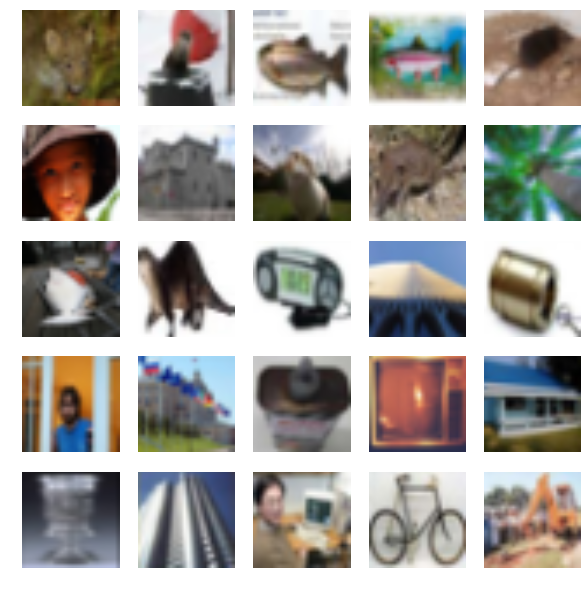

In [9]:
input_images = X
input_images_ = input_images.transpose((0, 2, 3, 1))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n, n
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

# Model

In [220]:
class Model(object):
    def __init__(self):
        self.extra_params = []
    def get_all_params(self, **kwargs):
        return (list(set(self.x_to_z.get_all_params(**kwargs) + 
                        self.z_to_x.get_all_params(**kwargs)))+self.extra_params)

In [221]:
model_type = "fully_connected"

In [265]:
from lasagne import init
if model_type == "fully_connected":
    ## fully connected
    latent_size = 200
    theta = theano.shared(np.array(0.1).astype(np.float32))
    #thresh = theano.shared(np.random.uniform(-0.001, 0.001, size=(latent_size,)).astype(np.float32))

    l_in = layers.InputLayer((None, nb_colors, w, h), name="input")
    l_latent = layers.DenseLayer(l_in, 
                                 num_units=latent_size,
                                 name="latent",
                                 W=init.Uniform(range=0.00001),
                                 #W=init.Uniform(range=0.001),
                                 #W=init.Uniform(range=0.27),
                                 #nonlinearity=T.nnet.sigmoid,
                                 nonlinearity=lambda x: (x>theta)*x,
                                 #nonlinearity=lambda x:rectify(x+thresh)* (x/(x+thresh)),
                                 #b=Constant(0.),
                                 #b=None
                                 )
    l_decoder_out = TransposedDenseLayer(l_latent, num_units=nb_colors*w*h,
                                         W=l_latent.W,
                                         #W=init.Uniform(range=0.2734344),
                                         #b=Constant(0.),
                                         nonlinearity=None)
    l_decoder_out = layers.ReshapeLayer(l_decoder_out, ([0], nb_colors, w, h))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    #model.extra_params.append(thresh)
    
    
    def show_filters(all_layers, shuffled=True, nbrows=10, nbcols=10):
        fig = plt.figure(figsize=(10, 10))
        V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
        min_val = V.min(axis=1)[:, None]
        max_val = V.max(axis=1)[:, None]
        V = (V - min_val) / (max_val - min_val)
        V = V.T.reshape((-1, nb_colors, w, h))
        V = V.transpose((0, 2, 3, 1)) 
        V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
        s = np.arange(V_.shape[0])
        np.random.shuffle(s)
        grid_plot(V_[s, :, :], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
        plt.show()

In [274]:
def show_filters(all_layers, shuffled=True, nbrows=10, nbcols=10):
    fig = plt.figure(figsize=(10, 10))
    V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
    V = V.T.reshape((-1, nb_colors, w, h))
    #min_val = V.min(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    #max_val = V.max(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    min_val = V.min(axis=0)
    max_val = V.max(axis=0)
    V = (V - min_val) / (max_val - min_val)

    V = V.transpose((0, 2, 3, 1)) 
    V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
    s = np.arange(V_.shape[0])
    np.random.shuffle(s)
    grid_plot(V_[s, :, :], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
    plt.show()

In [275]:
if model_type == "convnet":
    filter_size = 5
    latent_size = 50
    num_filters = 64
    
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, 
                                filter_size=(filter_size, filter_size),
                                name="conv1")
    l_conv_2 = layers.Conv2DLayer(l_conv, num_filters=num_filters, 
                                  filter_size=(filter_size, filter_size),
                                  name="conv2")
    sw = w - 2 * filter_size + 2
    l_latent = Conv2DDenseLayer(l_conv_2, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    
    l_unconv_2 = layers.Conv2DLayer(l_un_latent, num_filters=num_filters, 
                                   filter_size=(filter_size, filter_size),
                                   pad="full",
                                   name="unconv_2")
    l_unconv = layers.Conv2DLayer(l_unconv_2, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  pad="full",
                                  name="unconv_1")

    l_decoder_out = l_unconv
    
    """
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, filter_size=(filter_size, filter_size), name="conv1")
    
    l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2), name="pool1")
    #l_pool = l_conv
    
    # sw = (w - filter_size + 1)
    sw = (w - filter_size + 1) / 2

    l_latent = Conv2DDenseLayer(l_pool, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    l_unpool = layers.Upscale2DLayer(l_un_latent, 2, name="unpool1")
    #l_unpool = l_un_latent
    l_unconv = layers.Conv2DLayer(l_unpool, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  #W=l_conv.W,
                                  name="unconv1",
                                  pad='full',
                                  nonlinearity=None)
    l_decoder_out = l_unconv
    """
    print(layers.get_output_shape(l_decoder_out, (100, 3, 28, 28)))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    
    
    def show_filters(all_layers):
        fig = plt.figure(figsize=(10, 10))
        V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
        V = V.transpose((0, 2, 3, 1)) 
        min_val = V.min(axis=(1, 2, 3))[:, None, None, None]
        max_val = V.max(axis=(1, 2, 3))[:, None, None, None]
        V = (V - min_val) / (max_val - min_val)
        V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
        grid_plot(V_, imshow_options={"cmap": "gray"})
        plt.show()

In [276]:
layers_by_name = OrderedDict()


all_layers = (
    layers.get_all_layers(model.x_to_z.output_layers[0]) +
    layers.get_all_layers(model.z_to_x.output_layers[0])
)

for l in all_layers:
    if l.name is not None:
        layers_by_name[l.name] = l
print(layers_by_name.keys())

['input', 'latent']


## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [277]:
input_variables = OrderedDict()
input_variables["input_image"] = dict(tensor_type=T.tensor4)

In [278]:
def loss_function(model, tensors, noise=False):
    input_image = tensors["input_image"]    
    input_image_old = input_image
    #noisify
    if noise is True:
        print(noise)
        #input_image = input_image * (rng.uniform(size=input_image.shape) <= 0.7)
        input_image = input_image + rng.normal(std=0.01, size=input_image.shape)
    output = get_output(model, input_image)    
    
    recons = ((input_image_old - output) ** 2)
    #recons = (input_image_old * T.nnet.softplus(-output) + (1 - input_image_old) * T.nnet.softplus(output))
    recons = recons.sum(axis=(1, 2, 3))
    return recons.mean()

def get_latent(model, input_image):
    z, = model.x_to_z.get_output(input_image)
    return z

def get_output(model, input_image):
    z = get_latent(model, input_image)
    o, = model.z_to_x.get_output(z)
    return o

def get_output_from_latent(model, latent):
    o, = model.z_to_x.get_output(latent)
    return o

def get_loss(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=True)

def get_loss_deterministic(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=False)

functions = dict(
    get_output=dict(
        get_output=get_output,
        params=["input_image"]
    ),   
    get_latent=dict(
        get_output=get_latent,
        params=["input_image"]
    ),
    get_loss=dict(
        get_output=get_loss,
        params=["input_image"]
    ),
    get_loss_deterministic=dict(
        get_output=get_loss_deterministic,
        params=["input_image"]
    )
  
)

class MyBatchOptimizer(BatchOptimizer):
    # called for each epoch during training
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        nb = 200
        status["train_loss"] = self.model.get_loss_deterministic(X[train][0:nb])
        status["test_loss"] = self.model.get_loss_deterministic(X[test][0:nb])

        if (status["epoch"] % 10) == 0:
            show_filters(all_layers)
        return status

In [279]:
batch_optimizer = MyBatchOptimizer(
    max_nb_epochs=10,
    verbose=1,
    batch_size=100,
    optimization_procedure=(updates.rmsprop, {"learning_rate": 0.0001})
)

In [280]:
theta.set_value(1)

In [281]:
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)

True


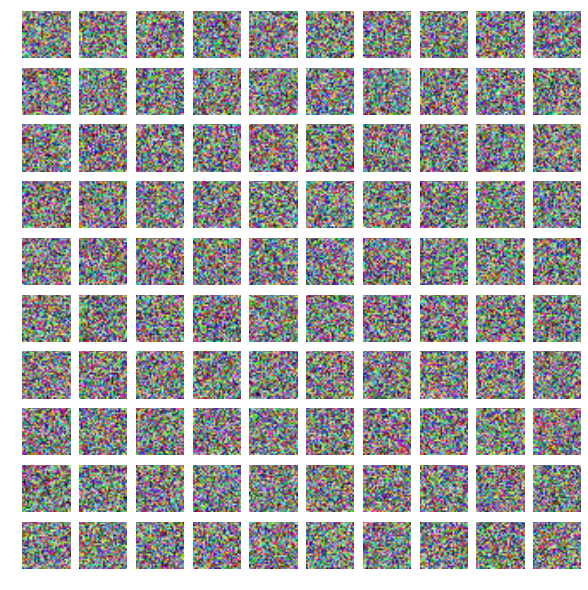

  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      0     46.7662       650.026       593.348      613.621
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      1     42.5764       558.823       507.674      527.219
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      2     38.4434       477.153       431.502       450.32
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      3     34.3394       404.985       364.828       382.92
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      4      30.276       342.313       307.647      325.014
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ---

In [282]:
%%time
capsule.fit(input_image=X[train])

In [ ]:
print(model.extra_params[0].get_value())

## checking performance

In [209]:
input_images = X
input_images = input_images[np.random.randint(0, input_images.shape[0], size=150)]
output_images = capsule.get_output(input_images)

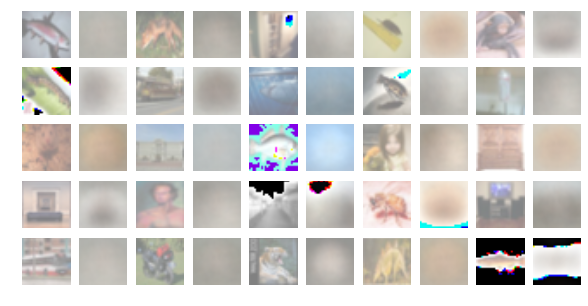

In [215]:
input_images_ = input_images.transpose((0, 2, 3, 1))

def a(x):
    return x
    return 1./(1.+np.exp(-x))
output_images_ = a(output_images.transpose((0, 2, 3, 1)))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
if output_images_.shape[-1] == 1:
    output_images_ = output_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n*2, n*2
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(output_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

## Apply blending

In [ ]:
#!wget http://i.imgur.com/2HVJF0t.gif --output-document=image.gif
#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/cheval%201/images/chevaux_1_015.gif --output-document=image.gif

#!wget http://i.imgur.com/iqZBF6A.jpg --output-document=image.jpg # im1
#!wget http://jmg.j.m.pic.centerblog.net/it3ahbzg.jpg --output-document=image.jpg #im2
#!wget http://jmg.j.m.pic.centerblog.net/c4j703bp.jpg --output-document=image.jpg #im3
#!wget http://www.freelargeimages.com/wp-content/uploads/2014/12/Landscape_01.jpg --output-document=image.jpg # im4

#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/chevaux%205/images/chevaux_5_008.gif --output-document=image.gif
#!wget http://www2.mes-coloriages-preferes.biz/colorino/Images/Large/Animaux-Cheval-3756.png --output-document=image.gif
#!wget https://sustainability.uic.edu/files/2013/11/Tree.jpg --output-document=image.jpg --no-check-certificate
#!wget http://www.vbctulsa.com/wordpress/wp-content/uploads/2015/02/wrackthetree.jpg --output-document=image.jpg

In [ ]:
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
image = (imread("image.jpg"))
print(image.shape)
image = resize(image, (256, 256))
#image = image[:, :, 0] # RGB?
#print(image)
image = 1 - image
if len(image.shape) == 2:
    image = image[:, :, None] * np.ones((1, 1, nb_colors))
print(image.shape)

In [ ]:
fig = plt.figure(figsize=(5, 5))
im = image[:, :, 0] if nb_colors == 1 else image
orig_im = im.copy()
plt.imshow(1-im, cmap="gray")

In [ ]:
image_ = (image.transpose((2, 0, 1)).astype(np.float32))[None, :, :, :].copy()
print(image_.shape)
for i in range(3):
    image_ = capsule.get_output(image_)
image__ = image_.transpose((0, 2, 3, 1))

im = image__[0, :, :, 0] if nb_colors == 1 else image__[0]

alpha=0.03
im = (im - im.min()) / (im.max() - im.min())
fig = plt.figure(figsize=(5, 5))
plt.imshow( (1-im), cmap="gray")

## weights

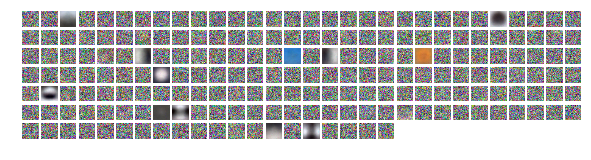

In [208]:
show_filters(all_layers, nbrows=30, nbcols=30)